In [1]:
ids=[2350, 4574, 474, 3424, 5240, 110, 834, 3642, 119, 373, 3306, 4566, 2266, 3752, 2750, 1253, 746, 1662, 1784, 744, 94, 1476, 3734, 3582, 2760, 4845, 3761, 1580, 378, 873, 3497, 2819]
ids2=[5482,5490,5581]
ids=ids+ids2

In [2]:
import h5py
import numpy as np
from scipy import signal
import glob
import matplotlib.pyplot as plt
from obspy import UTCDateTime as UTC
import obspy
import math
import os
from matplotlib.offsetbox import AnchoredText

In [3]:
def maximum_snr(tr):
    data=np.abs(tr.data)
    signal=np.mean(np.abs(np.sort(data)[-100:]))
    noise=np.mean(np.abs(data[:500]))
    snr = 10*np.log10(signal/noise)
    return snr

def stalta_snr(tr,sta,lta):
    df = tr.stats.sampling_rate
    func=classic_sta_lta(tr,df*sta,df*lta)
    return np.max(func)

def locate_average(data,length,mode='maximum'):
    ave=[]
    for i in range(len(data)-length+1):
        ave.append(np.mean(data[i:length+i]))
        
    if mode =='maximum':
        return np.max(ave)
    elif mode =='minimum':
        return np.min(ave)
    else: 
        raise 'error'
        
def snr(data,st,lt,fs):
    signal=locate_average(data,st*fs,'maximum')
    noise=locate_average(data,lt*fs,'minimum')
    snr=10*np.log10(signal/noise)
    return snr

In [4]:
def read_prem_file(file):
    
    #### Return detection time, magntiude, depth, distance and a list of matched channels of the earthquake
    #### Note other channels may also detect the earthquake, but the similarity doesn't pass certain threshold
    #### Also note hand picked files don't have matched channels info
    
    
    f=open(file,'r')
    sampling_rate=100
    
    lines=f.readlines()
    for line in lines:
        if line.startswith('File start time'):
            stime=UTC(line.split('File start time (UTC+9):')[1])
            break
            
    dtime=stime+20
    etime=stime+60
    
    for line in lines:
        if line.startswith('Passed QA text:'):
            if line.split('Passed QA text: ')[1][:3] == 'Yes':
                qual='Y'
            else:
                qual='N'
    
    for line in lines:
        if line.startswith('Magnitude'):
            mag=line.split('Magnitude: ')[1]
            if mag == 'unknown' or 'unknown\n':
                pass
            else:
                mag=float(mag)
            break
                
    for line in lines:
        if line.startswith('Depth'):
            dep=line.split('Depth (km): ')[1]
            
            if dep == 'unknown':
                pass
            else:
                dep=float(dep)
            break
            
    for line in lines:
        if line.startswith('Distance'):
            dist=line.split('Distance (km): ')[1]
            
            if dist == 'unknown':
                pass
            else:
                dist=float(dist)
            break
            
    channels=[]
    for line in lines:
        if line.startswith('Matched channels'):
            idx=lines.index(line)
            
            for i in range(idx+1,len(lines)):
                channels.append(int(lines[i]))
                
            break
                
    return dtime,mag,dep,dist,channels,qual

In [5]:
def obspy_filter(data,lowcut,highcut,fs,order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    z, p, k = signal.iirfilter(order, [low, high], btype='band',
                        ftype='butter', output='zpk')
    sos = signal.zpk2sos(z, p, k)
    new_data=signal.sosfilt(sos, data)
    return new_data

def highpass_filter(data,ff,fs,order=4,axis=0):
    nyq = 0.5 * fs
    ff = ff / nyq
    z, p, k = signal.iirfilter(order, ff, btype='highpass',
                        ftype='butter', output='zpk')
    sos = signal.zpk2sos(z, p, k)
    new_data=signal.sosfilt(sos, data,axis)
    return new_data


def get_das_data(index):
    
    file='/nfs/turbo/lsa-zspica/shared/for_jiuxun/prem_model_events/index'+index+'/index'+index+'_info.txt'
    stime=read_prem_file(file)[0]
    UTCtime=stime-9*3600
    folder='/nfs/turbo/lsa-zspica/data/Kamaishi/DAS/RAW/DATA_exp2/2019/'+str(UTCtime.month).zfill(2)+'/'+str(UTCtime.day).zfill(2)
    h5s=np.sort(glob.glob(folder+'/*.hdf5'))
    
    for i in range(len(h5s)):
        h5=h5s[i]
        filetime=UTC(h5py.File(h5,'r')['Metadata']['Timestamp'][0])
        if filetime>UTCtime:
            fileindex=i-1
            break
        else:
            fileindex=len(h5s)
            
    if fileindex != len(h5s):
        filestarttime=UTC(h5py.File(h5s[fileindex],'r')['Metadata']['Timestamp'][0])    
        delta=int(500*(UTCtime-filestarttime))
        if delta<=120000:
            data=h5py.File(h5s[fileindex],'r')['DAS'][delta:(delta+30000),10245:10285]
        else:
            data1=h5py.File(h5s[fileindex],'r')['DAS'][delta:,10245:10285]
            data2=h5py.File(h5s[fileindex+1],'r')['DAS'][:(delta-120000),10245:10285]
            data=np.concatenate((data1,data2),axis=0)
            
    else:
        filestarttime=UTC(h5py.File(h5s[fileindex],'r')['Metadata']['Timestamp'][0])    
        delta=int(500*(UTCtime-filestarttime))
        if delta<=120000:
            data=h5py.File(h5s[fileindex],'r')['DAS'][delta:(delta+30000),10245:10285]
        else:
            data1=h5py.File(h5s[fileindex],'r')['DAS'][delta:,10245:10285]
            UTCtime2=UTCtime+300
            folder2='/nfs/turbo/lsa-zspica/data/Kamaishi/DAS/RAW/DATA_exp2/2019/'+str(UTCtime2.month).zfill(2)+'/'+str(UTCtime2.day).zfill(2)
            file2=np.sort(glob.glob(folder2+'/*.hdf5'))[0]
            data2=h5py.File(file2,'r')['DAS'][:(delta-120000),10245:10285]
            data=np.concatenate((data1,data2),axis=0)  
        
    return data,stime

def get_obs_data(stime):
    mseeds=np.sort(glob.glob('/nfs/turbo/lsa-zspica/data/Kamaishi/OBS/exp2/Acceleration_data_v2/*.mseed'))
    for mseed in mseeds:
        if mseed[-8:-6]==str(stime.day).zfill(2):
            stname=mseed
            break      
    st=obspy.read(mseed)
    st.trim(stime,stime+60)
#     st.filter('bandpass',freqmin=1,freqmax=12)
    return st[0].data/1000

def convert_das(data,stacking=-1):
    if stacking == -1:
        data=np.sum(data,axis=-1)/data.shape[-1]
    else:
        data=data[:,stacking]
        
    phase=np.cumsum(data*np.pi/32768,dtype='float')
    strain=phase*1550*10**-9/(4*np.pi*1.47*0.78*40)
    velocity=strain*3500

    acceleration=[0]
    for i in range(1,len(velocity)):
        acceleration.append((velocity[i]-velocity[i-1])*500)
        
    acceleration=signal.detrend(acceleration)
    acceleration=signal.decimate(acceleration,5)
    acceleration=signal.detrend(acceleration)
#     converted=obspy_filter(acceleration,1,12,100)
   
    return acceleration*10**6

def locate_max_energy(data,winlen=5*100,step=10):
    
    intervals=int(len(data)-winlen)//step
    energies=[]
    
    for i in range(intervals):
        start=i*step
        energies.append(np.sum((data[start:start+winlen]*10**-6)**2))
    return np.max(energies)

# figure 5

In [6]:
group1_das_energy_npys=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/*.npy'))
group1_das_energy=[]
for das in group1_das_energy_npys:
    data=np.load(das)[:,2053]
    print(das,data.shape)
    group1_das_energy.append(locate_max_energy(data,winlen=10*100,step=10))
    
group1_das_snr=[]
group1_das_snrs=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/snr/*.npy'))
for d in group1_das_snrs:
    group1_das_snr.append(np.load(d)[2053])

group1_obs_energy_npys=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/obs/*.npy'))
group1_obs_energy=[]
for obs in group1_obs_energy_npys:
    data=np.load(obs)
    group1_obs_energy.append(locate_max_energy(data,winlen=10*100,step=10))

/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0094.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0110.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0119.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0373.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0378.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0474.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0744.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0746.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0834.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/0873.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/1253.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable/das/1476.npy (6000,)
/nfs/turbo/lsa-z

In [7]:
group2_das_energy_npys=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/*.npy'))
group2_das_energy=[]
for das in group2_das_energy_npys:
    data=np.load(das)[:,2053]
    print(das,data.shape)
    group2_das_energy.append(locate_max_energy(data,winlen=10*100,step=10))
    
group2_das_snr=[]
group2_das_snrs=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/snr/*.npy'))
for d in group2_das_snrs:
    group2_das_snr.append(np.load(d)[2053])

group2_obs_energy_npys=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/obs/*.npy'))
group2_obs_energy=[]
for obs in group2_obs_energy_npys:
    data=np.load(obs)
    group2_obs_energy.append(locate_max_energy(data,winlen=10*100,step=10))

/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0004.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0035.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0036.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0063.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0085.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0086.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0094.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0108.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0110.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0119.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0146.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/0148.npy (6000,)
/nfs

/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1192.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1212.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1237.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1246.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1253.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1260.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1310.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1342.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1376.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1395.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1407.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/1411.npy (6000,)
/nfs

/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2208.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2209.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2217.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2230.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2266.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2278.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2280.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2290.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2314.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2319.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2326.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/2330.npy (6000,)
/nfs

/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3072.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3079.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3142.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3143.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3145.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3149.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3151.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3154.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3168.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3181.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3189.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/3192.npy (6000,)
/nfs

/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4252.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4257.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4270.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4273.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4280.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4314.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4322.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4347.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4385.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4389.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4392.npy (6000,)
/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/all_cable2/das/4407.npy (6000,)
/nfs

In [8]:
obsnpys=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/data/Japan_noise/OBS_noise/*.npy')
obsnoise=np.load(obsnpys[0])
for i in range(1,len(obsnpys)):
    obsnoise=np.append(obsnoise,np.load(obsnpys[i]))
obsmedian=np.median(obsnoise)

In [9]:
dasnpys=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/data/Japan_noise/*.npy'))
dasnoise=np.load(dasnpys[0])
for das in dasnpys[1:]:
    dasnoise=np.concatenate((dasnoise,np.load(das)))
dasmedian=np.median(dasnoise)

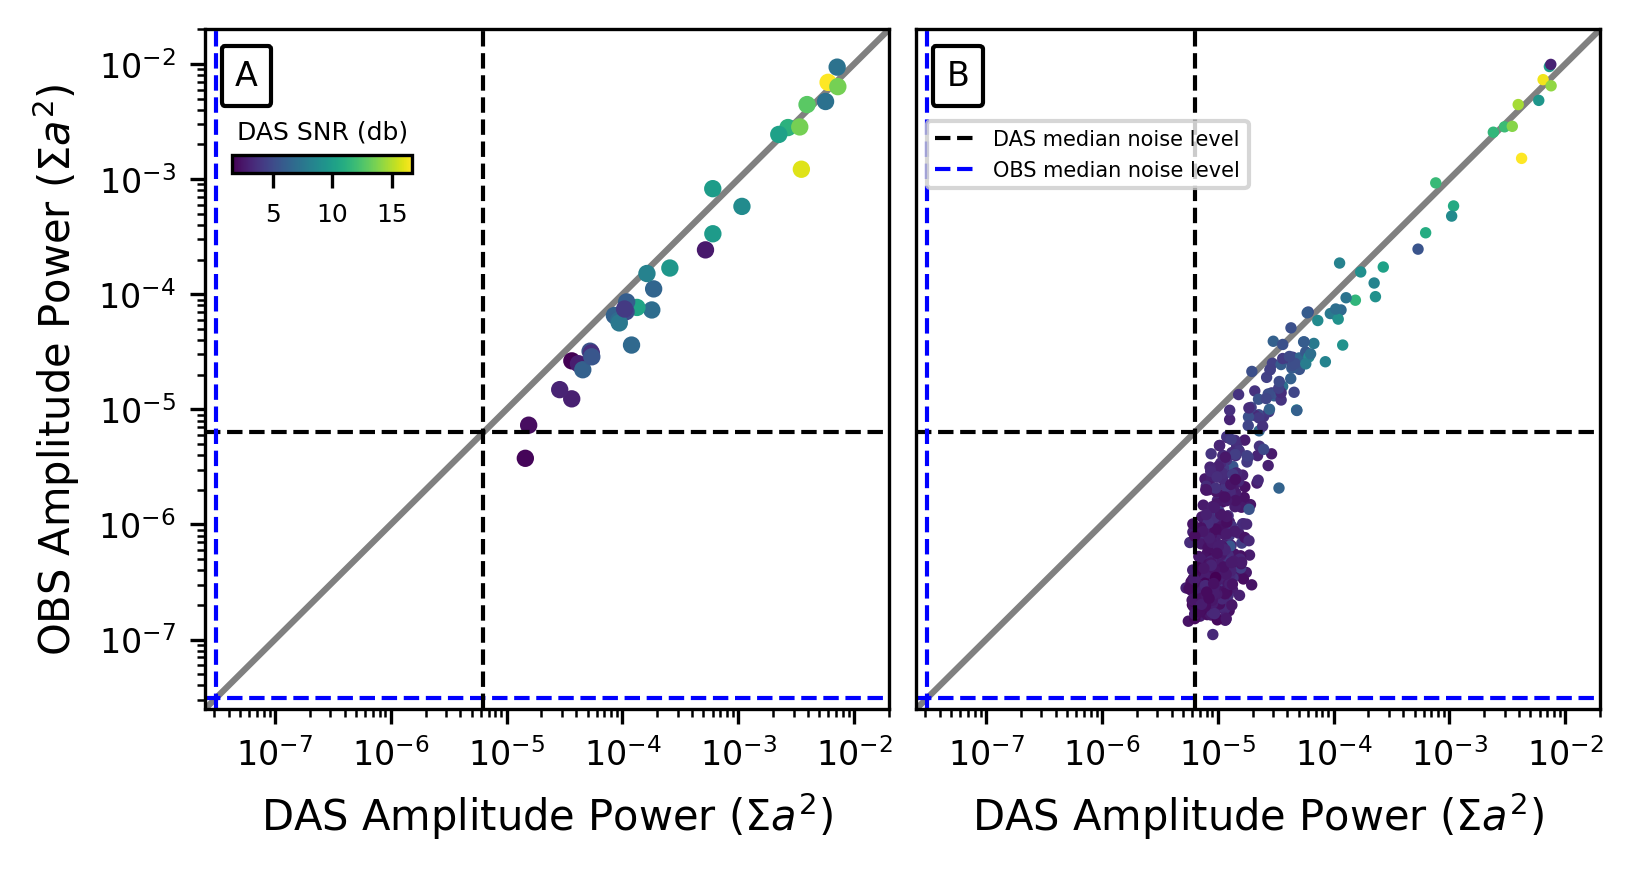

In [10]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(6,3))
plt.subplots_adjust(wspace=0.04)
fig.dpi=300

ax1.plot(np.arange(0,1,1/10000),np.arange(0,1,1/10000),c='grey',zorder=0)
ax1.scatter(group1_das_energy,group1_obs_energy,c=group1_das_snr,s=10)

ax1.hlines(dasmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='k')
ax1.hlines(obsmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='blue')
ax1.vlines(dasmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='k')
ax1.vlines(obsmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='blue')
ax1.set_xlim(2.5*10**-8,2*10**-2)
ax1.set_ylim(2.5*10**-8,2*10**-2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('DAS Amplitude Power ($\Sigma a^2$)')
ax1.set_ylabel('OBS Amplitude Power ($\Sigma a^2$)')
ax1.tick_params(labelsize=8)

at=AnchoredText('A',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax1.add_artist(at)

###
ax2.plot(np.arange(0,1,1/10000),np.arange(0,1,1/10000),c='grey',zorder=0)
sc=ax2.scatter(group2_das_energy,group2_obs_energy,c=group2_das_snr,s=3)

ax2.hlines(dasmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='k',label='DAS median noise level')
ax2.hlines(obsmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='blue',label='OBS median noise level')
ax2.vlines(dasmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='k')
ax2.vlines(obsmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='blue')
ax2.set_xlim(2.5*10**-8,2*10**-2)
ax2.set_ylim(2.5*10**-8,2*10**-2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('DAS Amplitude Power ($\Sigma a^2$)')
ax2.tick_params(left=False,which="both")
ax2.set_yticklabels([])
ax2.tick_params(labelsize=8)
ax2.legend(loc='upper left',prop={'size':5},bbox_to_anchor=[0,0.88])

at=AnchoredText('B',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax2.add_artist(at)

cax=fig.add_axes([0.14,0.72,0.1,0.02])
cbar=fig.colorbar(sc, cax=cax,orientation='horizontal')
cbar.set_label('DAS SNR (db)',fontsize=6)
cbar.ax.tick_params(labelsize=6)
cbar.ax.xaxis.set_label_position('top')

# Figure_4_5_combined

In [12]:
class trace():
    
    def __init__ (self,data,samp_rate):
        self.data=data
        self.data_len = len(data)
        self.spectrum = np.fft.fft(data)[:int(self.data_len/2)]
        self.freq = np.fft.fftfreq(self.data_len,1/samp_rate)[:int(self.data_len/2)]
        
        
    def multi_filter(self, filter_freqs, bandwidth):

        class Gauss():
            def __init__(self, f0, a=1.0):
                self._omega0 = 2.*math.pi*f0
                self._a = a
            def evaluate(self, freqs):
                omega = 2.*math.pi*freqs
                return np.exp(-((omega-self._omega0)
                                 / (self._a*self._omega0))**2)

        freqs = self.freq
        coefs = self.spectrum
        n = self.data_len
        nfilt = len(filter_freqs)
        signal_tf = np.zeros((nfilt, n))
        centroid_freqs = np.zeros(nfilt)
        for ifilt, f0 in enumerate(filter_freqs):
            taper = Gauss(f0, a=bandwidth)
            weights = taper.evaluate(freqs)
            nhalf = freqs.size
            analytic_spec = np.zeros(n, dtype=complex)
            analytic_spec[:nhalf] = coefs*weights
            if n % 2 == 0:
                analytic_spec[1:nhalf-1] *= 2
            else:
                analytic_spec[1:nhalf] *= 2
            analytic = np.fft.ifft(analytic_spec)
            signal_tf[ifilt, :] = analytic.real
            enorm = np.abs(analytic_spec[:nhalf])**2
            enorm /= np.sum(enorm)
            centroid_freqs[ifilt] = np.sum(freqs*enorm)

        return centroid_freqs, signal_tf
    
def locate_max_energy(data,winlen=5*100,step=10):
    
    intervals=int(len(data)-winlen)//step
    energies=[]
    
    for i in range(intervals):
        start=i*step
        energies.append(np.sum((data[start:start+winlen]*10**-6)**2))
    return np.max(energies)

In [13]:
das_trs=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/Japan/eqs/DAS/raw/*.npy'))
obs_trs=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/Japan/eqs/OBS/raw/*.npy'))
ex=trace(np.load(obs_trs[0])[:6000],100)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

fqs2=np.exp(np.linspace(np.log(0.5),np.log(20),20))

In [16]:
ids=np.sort(ids)
magnitude=[]
distance=[]

for i in range(len(ids)):
    index=str(ids[i]).zfill(4)
    file='/nfs/turbo/lsa-zspica/work/yaolinm/for_jiuxun/prem_model_events/index'+index+'/index'+index+'_info.txt'
    magnitude.append(float(read_prem_file(file)[1]))
    distance.append(float(read_prem_file(file)[3]))
    
sorted_mag=np.sort(np.array(magnitude))
sorted_dist=np.array(distance)[np.argsort(np.array(magnitude))]

reordered_obs=obs_trs[np.argsort(np.array(magnitude))]
reordered_das=das_trs[np.argsort(np.array(magnitude))]

text=[]
for i in range(len(sorted_mag)):
    mag=sorted_mag[i]
    text.append('M='+str(mag))

Text(0.5, 0.04, 'Frequency (Hz)')

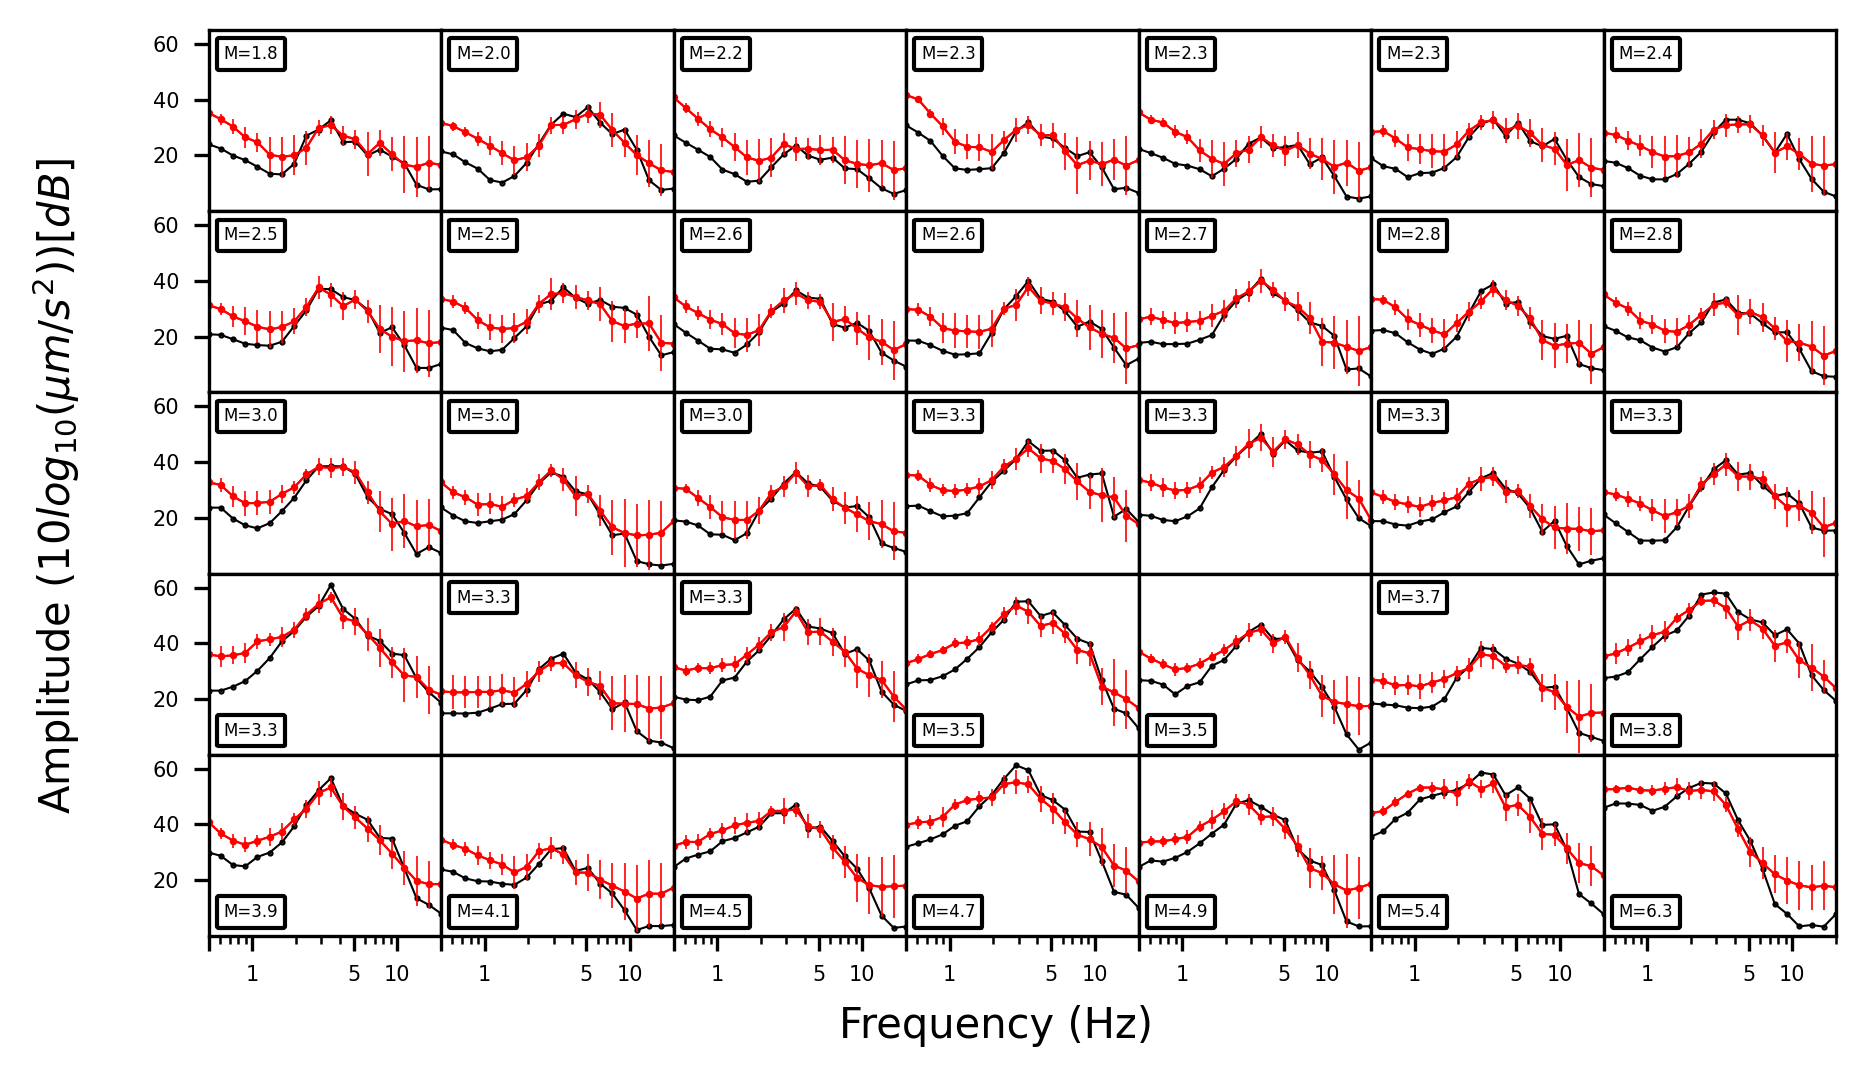

In [21]:
infomat=np.zeros((35,3,20)) ###DAS,OBS,EBAR

fig,axs=plt.subplots(5,7,dpi=300,figsize=(7,4))
axs=axs.flatten()
fig.subplots_adjust(wspace=0, hspace=0)

for a in range(len(axs)):
    obs=np.load(reordered_obs[a])
    das=np.load(reordered_das[a])
    das=convert_das(das,stacking=-1)
    
    f,obsden=signal.periodogram(obs, 100)
    f,dasden=signal.periodogram(das, 100)
    dasd=[]
    obsd=[]
    for fq in fqs2:
        idx=find_nearest(f,fq)
        dasd.append(np.median(dasden[idx-20:idx+20]))
        obsd.append(np.median(obsden[idx-20:idx+20]))
        
    axs[a].plot(fqs2,np.log10(dasd)*10,'r',marker='o',markersize=0.5,lw=0.5)
    axs[a].plot(fqs2,np.log10(obsd)*10,'k',marker='o',markersize=0.5,lw=0.5)

    das_raw=np.load(reordered_das[a])
    das2=np.zeros((6000,40))
    for i in range(das2.shape[-1]):
        das2[:,i]=convert_das(das_raw,stacking=i)

    dasden2=np.zeros((3001,40))
    for i in range(40):
        f,dasden2[:,i]=signal.periodogram(das2[:,i], 100)

    dasd2=np.zeros((20,40),dtype='float32')

    for i in range(len(fqs2)):
        fq=fqs2[i]
        idx=find_nearest(f,fq)
        for k in range(40):
            dasd2[i,k]=np.median(dasden2[idx-20:idx+20,k])
            
    sigma=np.std(dasd2,axis=-1)*2
    ebar=np.log10(dasd+sigma)*10-np.log10(dasd)*10
    
    infomat[a,0,:]=np.log10(dasd)*10
    infomat[a,1,:]=np.log10(obsd)*10
    infomat[a,2,:]=ebar
    
    axs[a].set_xscale('log')
    axs[a].errorbar(fqs2,np.log10(dasd)*10,yerr=ebar,c='r',lw=0.5,marker='o',markersize=0.8,elinewidth=0.4)
    axs[a].set_ylim(0,65)
    axs[a].set_xlim(0.5*10**0,2*10**1)
    axs[a].set_xticks([])
    axs[a].set_xticklabels([])
    axs[a].set_yticks([])
    axs[a].set_yticklabels([])
    
    if a<=20 or a in [22,23,26]:
        loc='upper left'
    else:
        loc='lower left'
        
    at=AnchoredText(text[a],prop=dict(size=4), frameon=True,loc=loc)
    at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
    axs[a].add_artist(at)

for i in [0,7,14,21,28]:
    axs[i].set_yticks([20,40,60])
    axs[i].set_yticklabels([20,40,60],fontsize=5)

for i in range(28,35):
    axs[i].set_xticks([0.5,1,5,10])
    axs[i].set_xticklabels(['',1,5,10],fontsize=5)
    
fig.text(0.04, 0.5, 'Amplitude $(10log_{10}(\mu m/s^2))[dB]$', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center')

In [27]:
ave_infomat=np.mean(infomat,axis=0)

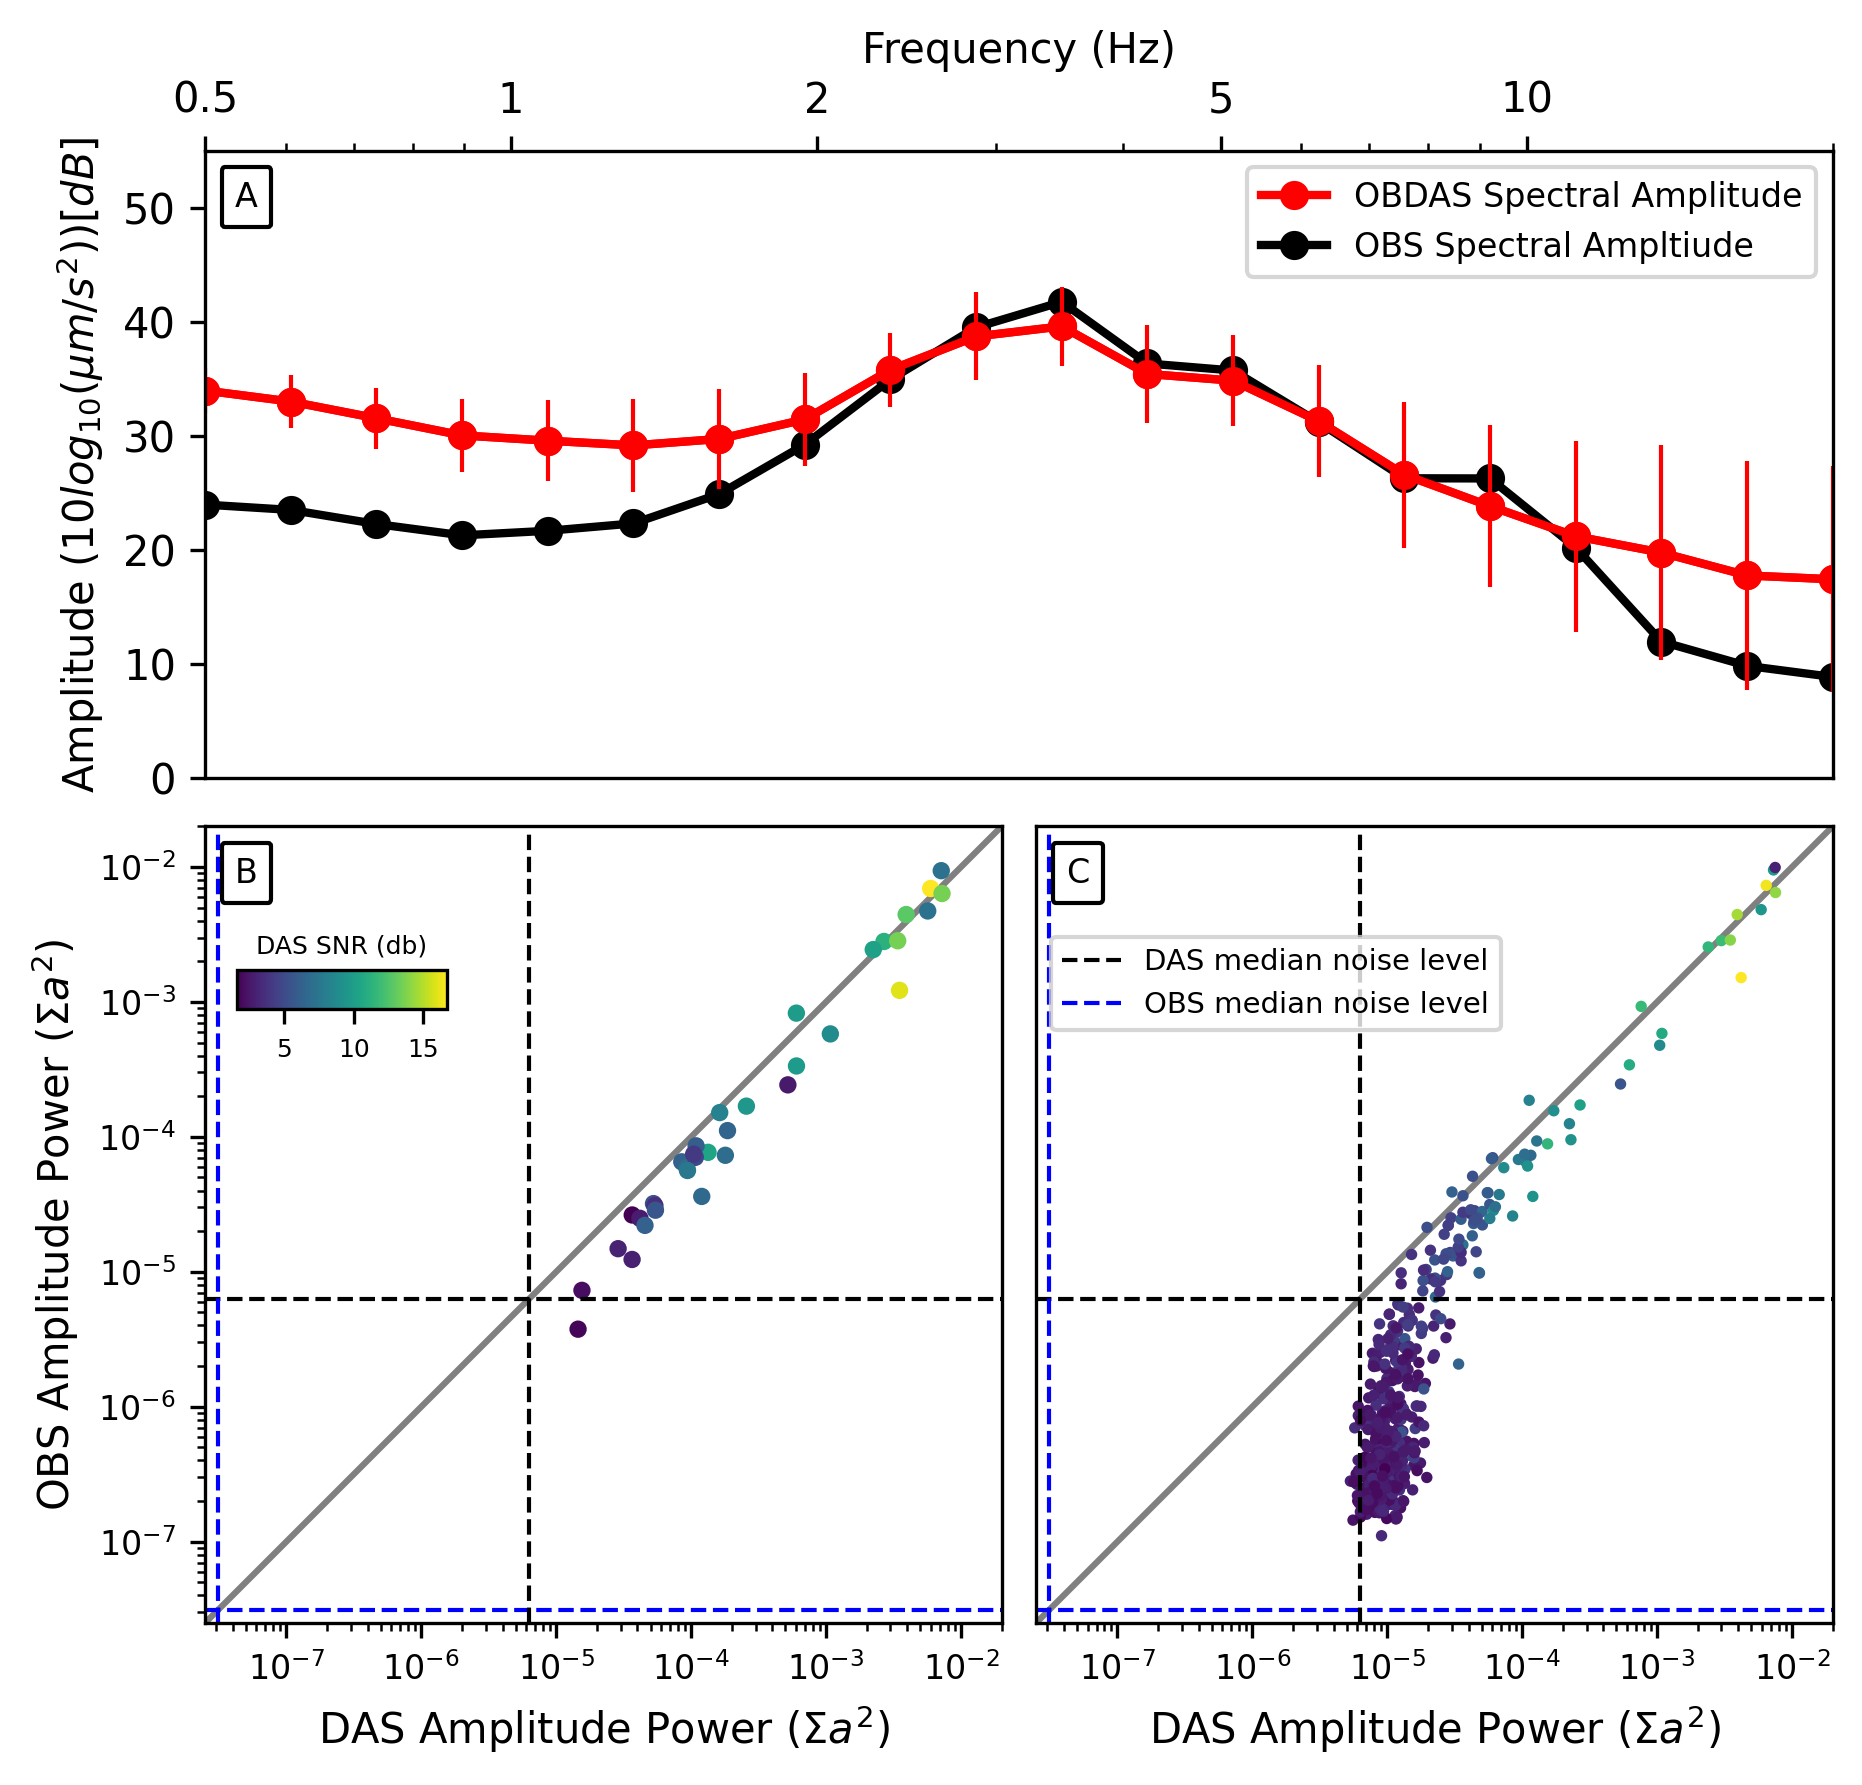

In [70]:
fig=plt.figure(figsize=(7,6.5),dpi=300)
fig.subplots_adjust(hspace=0.4,wspace=0.2)

ax0 = plt.subplot2grid(shape=(9,8), loc=(0,0), colspan=8,rowspan=4)
ax1 = plt.subplot2grid(shape=(9,8), loc=(4,0), colspan=4,rowspan=5)
ax2 = plt.subplot2grid(shape=(9,8), loc=(4,4), colspan=4,rowspan=5)

ax0.plot(fqs2,ave_infomat[0,:],'r',marker='o',markersize=6,lw=2,label='OBDAS Spectral Amplitude')
ax0.plot(fqs2,ave_infomat[1,:],'k',marker='o',markersize=6,lw=2,label='OBS Spectral Ampltiude')

ax0.set_xscale('log')
ax0.errorbar(fqs2,ave_infomat[0,:],yerr=ave_infomat[2,:],c='r',lw=2,marker='o',markersize=6,elinewidth=1)
ax0.set_ylim(0,55)
ax0.set_ylabel('Amplitude $(10log_{10}(\mu m/s^2))[dB]$')
ax0.set_xlim(0.5*10**0,2*10**1)

at=AnchoredText('A',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax0.add_artist(at)
ax0.legend(loc=1,fontsize=8)

ax0.set_xticks([0.5,1,2,5,10])
ax0.set_xticklabels([0.5,1,2,5,10])
ax0.set_xlabel('Frequency (Hz)')
ax0.xaxis.set_label_position('top') 
ax0.xaxis.tick_top()

# for i in [0,7,14,21,28]:
#     axs[i].set_yticks([20,40,60])
#     axs[i].set_yticklabels([20,40,60],fontsize=5)

# for i in range(28,35):
#     axs[i].set_xticks([0.5,1,5,10])
#     axs[i].set_xticklabels(['',1,5,10],fontsize=5)
    
ax1.plot(np.arange(0,1,1/10000),np.arange(0,1,1/10000),c='grey',zorder=0)
ax1.scatter(group1_das_energy,group1_obs_energy,c=group1_das_snr,s=10)

ax1.hlines(dasmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='k')
ax1.hlines(obsmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='blue')
ax1.vlines(dasmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='k')
ax1.vlines(obsmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='blue')
ax1.set_xlim(2.5*10**-8,2*10**-2)
ax1.set_ylim(2.5*10**-8,2*10**-2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('DAS Amplitude Power ($\Sigma a^2$)')
ax1.set_ylabel('OBS Amplitude Power ($\Sigma a^2$)')
ax1.tick_params(labelsize=8)

at=AnchoredText('B',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax1.add_artist(at)

###
ax2.plot(np.arange(0,1,1/10000),np.arange(0,1,1/10000),c='grey',zorder=0)
sc=ax2.scatter(group2_das_energy,group2_obs_energy,c=group2_das_snr,s=3)

ax2.hlines(dasmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='k',label='DAS median noise level')
ax2.hlines(obsmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='blue',label='OBS median noise level')
ax2.vlines(dasmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='k')
ax2.vlines(obsmedian,2.5*10**-8,2*10**-2,linestyle='--',lw=1,color='blue')
ax2.set_xlim(2.5*10**-8,2*10**-2)
ax2.set_ylim(2.5*10**-8,2*10**-2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('DAS Amplitude Power ($\Sigma a^2$)')
ax2.tick_params(left=False,which="both")
ax2.set_yticklabels([])
ax2.tick_params(labelsize=8)
ax2.legend(loc='upper left',prop={'size':7},bbox_to_anchor=[0,0.88])

at=AnchoredText('C',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax2.add_artist(at)

cax=fig.add_axes([0.14,0.44,0.1,0.02])
cbar=fig.colorbar(sc, cax=cax,orientation='horizontal')
cbar.set_label('DAS SNR (db)',fontsize=6)
cbar.ax.tick_params(labelsize=6)
cbar.ax.xaxis.set_label_position('top')